# Lab 4: Find Wally

In this exercise we are going to play the "Find wally" game. 

- **Inputs**: 
    You have 2 images, one with the Wally's profile, and another with the puzzle, were we should find Wally.

- **Expected result**:
    Visual location of Wally in the provided puzzle. 

## Requirements
You'll need the following libraries: 
- `ipykernel`
- `matplotlib`
- `opencv-python`
- `opencv-contrib-python`
- `nb_black`
- `ipympl`
- `scipy`
- `scikit-image`

## Guides
In the other notebook, we introduced Local Features. 
This exercise is a great example of the one application of the local features, especially due to its mental complexity. 

An option to implement this mini project is to: 
1. Find keypoints in both provided images
2. Build their descriptors
3. Match the descriptors between the 2 images
4. Run outlier removal algorithms to remove the incorrect matches.


In [ ]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2
%matplotlib inline

### 1. Read the input images

Steps: 
1. Read the two images
2. Convert them to RGB
3. Have a version of them in GrayScale

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load the image
img_wallys_face = cv2.imread("images/wally.png", 0)
img_find_wally = cv2.imread("images/find_wally.jpg", 0)

In [3]:
# Convert them to RGB

img_wallys_face_rgb = cv2.cvtColor(img_wallys_face, cv2.COLOR_BGR2RGB)
img_find_wally_rgb = cv2.cvtColor(img_find_wally, cv2.COLOR_BGR2RGB)

# Convert the images to GrayScale

img_wallys_face_gray = cv2.cvtColor(img_wallys_face_rgb, cv2.COLOR_RGB2GRAY)
img_find_wally_gray = cv2.cvtColor(img_find_wally_rgb, cv2.COLOR_RGB2GRAY)


Display the images:

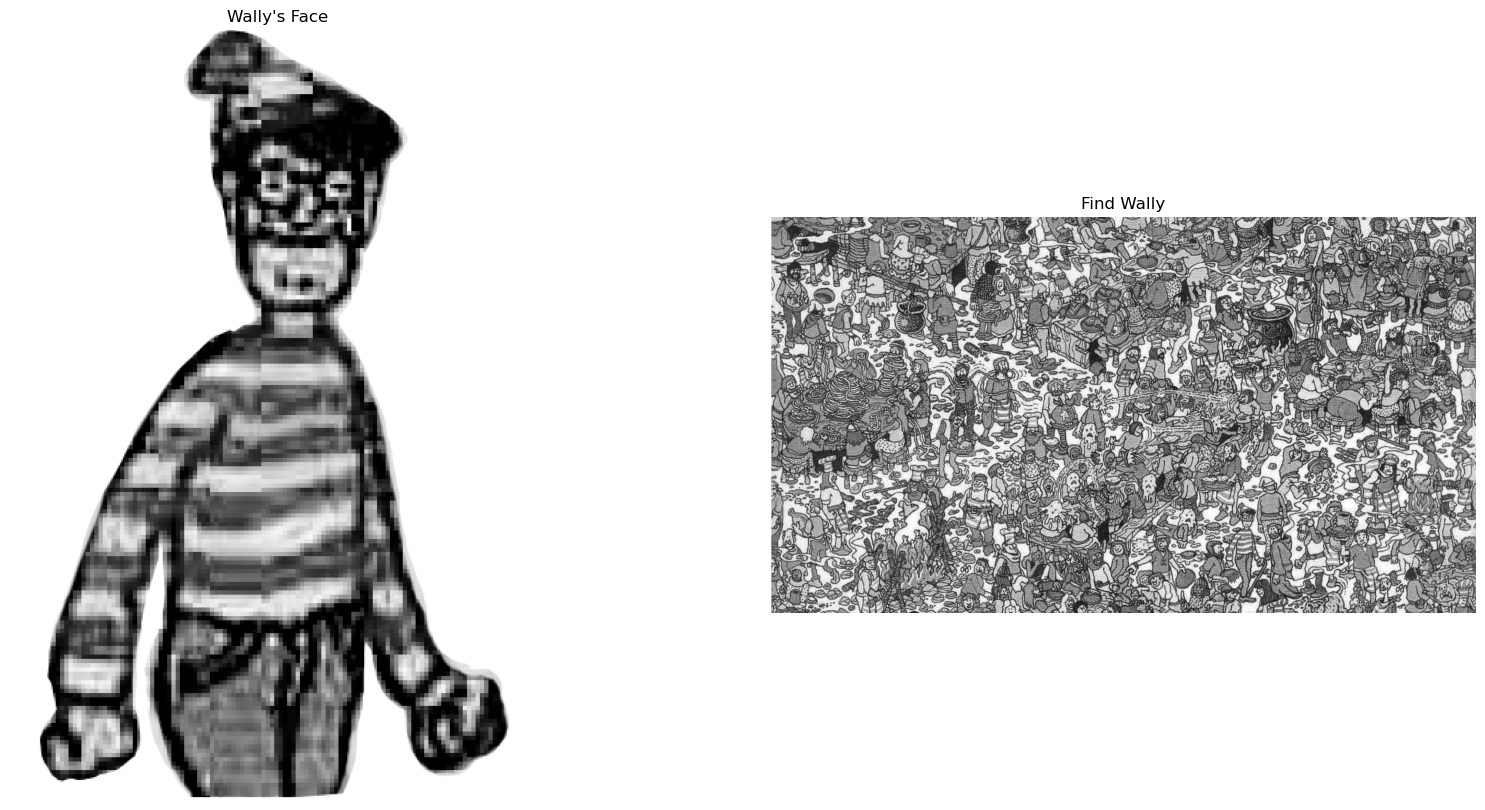

In [4]:
fx, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].set_title("Wally's Face")
ax[0].imshow(img_wallys_face_gray, cmap="gray")
ax[0].axis("off")

ax[1].set_title("Find Wally")
ax[1].imshow(img_find_wally_gray, cmap="gray")
ax[1].axis("off")
plt.show()

### 2. Detect keypoints and create descriptor

During the class we mentioned SIFT, however you can use any algorithm for detection and description.

Steps: 
1. Find keypoints from the 2 grayscale images
2. Store their descriptors 

In [12]:
# Create the SIFT detector

sift = cv2.SIFT_create()

# Find the keypoints from the 2 grayscale images and descriptors with SIFT

pattern_keypoints, descriptors_wallys_face = sift.detectAndCompute(
    img_wallys_face_gray, None
)
to_find_keypoints, descriptors_find_wally = sift.detectAndCompute(
    img_find_wally_gray, None
)


Draw keypoints in pattern's image - Wally's image.

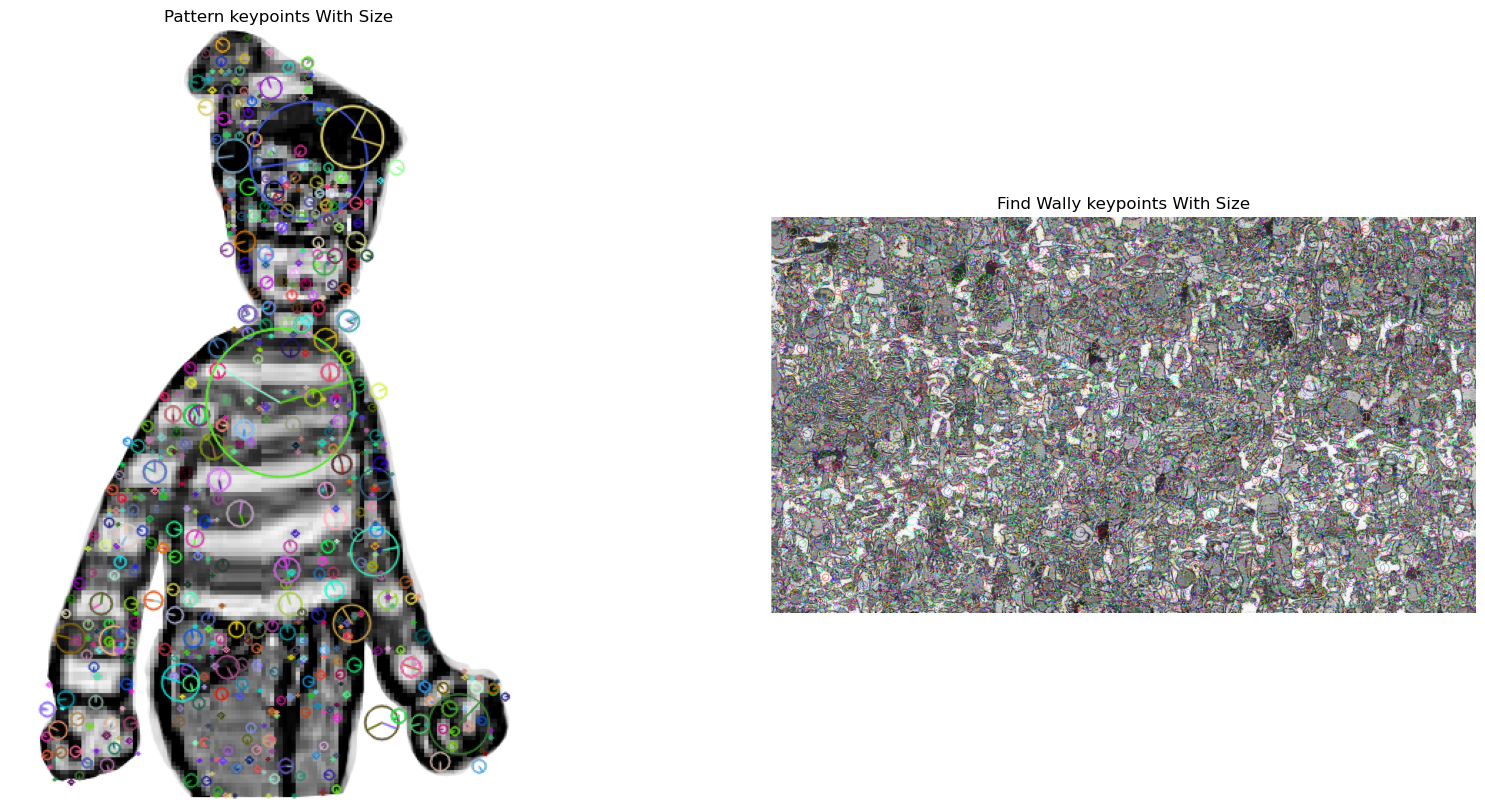

Number of Keypoints Detected In Wally's Image:  696


In [13]:
# Wally's face
keypoints_with_size = np.copy(img_wallys_face_rgb)

cv2.drawKeypoints(
    img_wallys_face_gray,
    pattern_keypoints,
    keypoints_with_size,
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS,
)

# Find Wally board
keypoints_with_size_find_wally = np.copy(img_find_wally_rgb)

cv2.drawKeypoints(
    img_find_wally_gray,
    to_find_keypoints,
    keypoints_with_size_find_wally,
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS,
)

# Print
fx, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].set_title("Pattern keypoints With Size")
ax[0].imshow(keypoints_with_size, cmap="gray")
ax[0].axis("off")

ax[1].set_title("Find Wally keypoints With Size")
ax[1].imshow(keypoints_with_size_find_wally, cmap="gray")
ax[1].axis("off")
plt.show()

# Print the number of keypoints detected in the wally image
print("Number of Keypoints Detected In Wally's Image: ", len(pattern_keypoints))

### 3. Match the descriptors between the 2 images - find correspondence

In [22]:
# Match the keypoints with the descriptors between the 2 images

# Create a Brute Force Matcher
bf = cv2.BFMatcher()

# Match the descriptors, with the Match algorithm

matches = bf.match(descriptors_wallys_face, descriptors_find_wally)

# Sort them in the order of their distance

matches = sorted(matches, key=lambda x: x.distance)

Print the matches

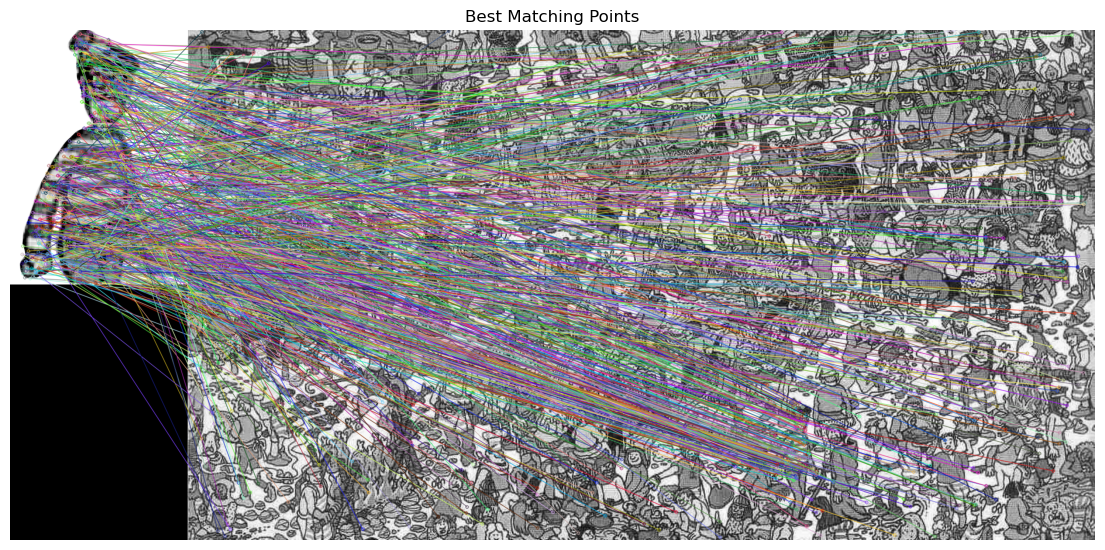


Number of Matching Keypoints Between The Training and Query Images:  696


In [23]:
result = cv2.drawMatches(
    img_wallys_face_rgb,
    pattern_keypoints,
    img_find_wally_rgb,
    to_find_keypoints,
    matches,
    img_find_wally_gray,
    flags=2,
)

# Display the best matching points
plt.rcParams["figure.figsize"] = [14.0, 7.0]
plt.title("Best Matching Points")
plt.imshow(result)
plt.axis("off")
plt.show()

# Print total number of matching points between Wally and the puzzle board
print(
    "\nNumber of Matching Keypoints Between The Training and Query Images: ",
    len(matches),
)

We can see that a lot of matches are incorrect. So we need a way to remove the outliers.

### 4. Remove the incorrect matches / outliers

In [27]:
# Remove the incorrect matches / outliers
# Find inlier keypoints from the left and from the right images

inlier_keypoints_left = np.float32(
    [pattern_keypoints[m.queryIdx].pt for m in matches]
)

inlier_keypoints_right = np.float32(
    [to_find_keypoints[m.trainIdx].pt for m in matches]
)

# Obtain the placeholder matches, with RANSAC algorithm

M, mask = cv2.findHomography(inlier_keypoints_left, inlier_keypoints_right, cv2.RANSAC)

# Get the dimensions of the Wally's face image
h, w = img_wallys_face_gray.shape

# Create a placeholder for the new image

placeholder = np.float32(
    [
        [0, 0],
        [0, h - 1],
        [w - 1, h - 1],
        [w - 1, 0],
    ]
).reshape(-1, 1, 2)

# Transform the placeholder image to the new image
new_image = cv2.perspectiveTransform(placeholder, M)

# Get the placeholder matches

placeholder_matches = mask.ravel().tolist()

See the result:

In [28]:
img_wally_found = cv2.drawMatches(
    img_wallys_face_rgb,
    inlier_keypoints_left,
    img_find_wally_rgb,
    inlier_keypoints_right,
    placeholder_matches,
    None,
)

# Display the best matching points
plt.rcParams["figure.figsize"] = [14.0, 7.0]
plt.title("After RANSAC")
plt.imshow(img_wally_found)
plt.axis("off")
plt.show()

error: OpenCV(4.9.0) :-1: error: (-5:Bad argument) in function 'drawMatches'
> Overload resolution failed:
>  - Can't parse 'keypoints1'. Sequence item with index 0 has a wrong type
>  - Can't parse 'keypoints1'. Sequence item with index 0 has a wrong type
>  - drawMatches() missing required argument 'matchesThickness' (pos 7)
>  - drawMatches() missing required argument 'matchesThickness' (pos 7)
